In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
#显示Dateframe所有列(参数设置为None代表显示所有行，也可以自行设置数字)
pd.set_option('display.max_columns',None)
#显示Dateframe所有行
pd.set_option('display.max_rows',None)
#设置Dataframe数据的显示长度，默认为50
pd.set_option('max_colwidth',200)
#不显示科学计数法，保留5位小数
pd.set_option('display.float_format', lambda x: '%.5f' % x)
import mplfinance as mpf
import numpy as np
import os
from tqdm import tqdm
from IPython.display import clear_output
from joblib import *
from alpha_factors.GTJA_Alpha191_analysis import GET_alpha

In [2]:
path = 'C:\\Users\\budin\\Desktop\\强化学习\\螺纹钢\\5分钟 - 副本\\数据\\'
dir_list = os.listdir(path)
train_df = pd.DataFrame()
for i in range(len(dir_list)):
    if 'train' in dir_list[i]:
        tmp_df = pd.read_csv(path+dir_list[i])
        train_df = train_df.append(tmp_df)
    else:
        pass
train_df = train_df.drop(columns='Unnamed: 0').rename(columns={'symbol':'underlaying_symbols', 'datetime': 'date'})
train_df['tic'] = ['RB']*len(train_df)
train_df = train_df[['date', 'tic', 'underlaying_symbols', 'open', 'high', 'low', 'close', 'volume', 'open_oi', 'close_oi']]
tickers = ['RB']

train_df.shape, train_df.head(5), train_df.dtypes

((6558, 10),
                   date tic underlaying_symbols       open       high  \
 0  2022-08-24 21:00:00  RB         SHFE.rb2210 4082.00000 4089.00000   
 1  2022-08-24 21:05:00  RB         SHFE.rb2210 4089.00000 4100.00000   
 2  2022-08-24 21:10:00  RB         SHFE.rb2210 4086.00000 4095.00000   
 3  2022-08-24 21:15:00  RB         SHFE.rb2210 4085.00000 4090.00000   
 4  2022-08-24 21:20:00  RB         SHFE.rb2210 4084.00000 4091.00000   
 
          low      close      volume       open_oi      close_oi  
 0 4081.00000 4086.00000 45466.00000 1289350.00000 1288077.00000  
 1 4083.00000 4086.00000 65069.00000 1288077.00000 1286786.00000  
 2 4082.00000 4085.00000 23530.00000 1286786.00000 1285704.00000  
 3 4079.00000 4084.00000 18618.00000 1285704.00000 1284464.00000  
 4 4082.00000 4091.00000 16848.00000 1284464.00000 1283701.00000  ,
 date                    object
 tic                     object
 underlaying_symbols     object
 open                   float64
 high           

# Reduce Contract Change Gap

In [3]:
contracts = train_df['underlaying_symbols'].unique()
indexes = []
for i in range(len(contracts)):
    tmp_df = train_df[train_df['underlaying_symbols']==contracts[i]]
    tmp_index = tmp_df.index
    indexes.append([tmp_index])
    
indexes

[[Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
              ...
              210, 211, 212, 213, 214, 215, 216, 217, 218, 219],
             dtype='int64', length=220)],
 [Int64Index([ 220,  221,  222,  223,  224,  225,  226,  227,  228,  229,
              ...
              4127, 4128, 4129, 4130, 4131, 4132, 4133, 4134, 4135, 4136],
             dtype='int64', length=3917)],
 [Int64Index([4137, 4138, 4139, 4140, 4141, 4142, 4143, 4144, 4145, 4146,
              ...
              6548, 6549, 6550, 6551, 6552, 6553, 6554, 6555, 6556, 6557],
             dtype='int64', length=2421)]]

## Inspect Individual Price Gaps 

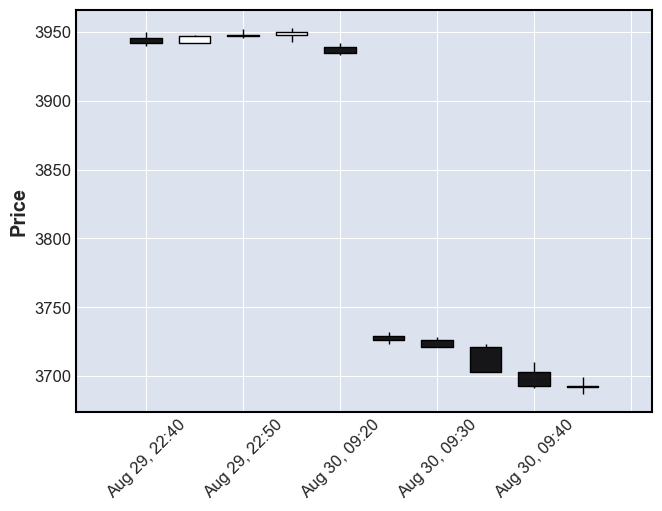

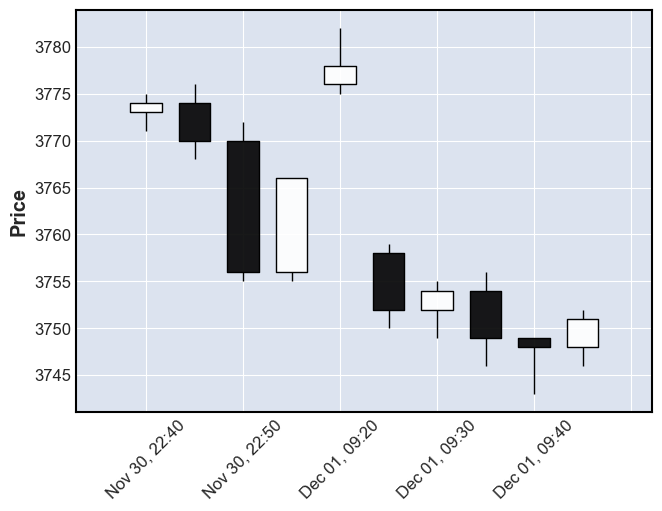

In [4]:
for i in range(1, len(contracts)):
    last_index_end = indexes[i-1][0][-5]
    this_index_start = indexes[i][0][5]
    tmp_df = train_df.iloc[last_index_end:this_index_start].set_index('date')
    tmp_df.index = pd.to_datetime(tmp_df.index)
    mpf.plot(tmp_df, type='candle')

## Adjust Individual Price Gaps

In [5]:
price_adjs = []
for i in range(1, len(contracts)):
    tmp_index = indexes[i][0]
    last_price = train_df['close'].iloc[indexes[i-1][0][-1]]
    now_price = train_df['close'].iloc[indexes[i][0][0]]
    price_adj = now_price - last_price
    print(price_adj)
    train_df['close'].iloc[tmp_index] = train_df['close'].iloc[tmp_index] - price_adj
    train_df['high'].iloc[tmp_index] = train_df['high'].iloc[tmp_index] - price_adj
    train_df['low'].iloc[tmp_index] = train_df['low'].iloc[tmp_index] - price_adj
    train_df['open'].iloc[tmp_index] = train_df['open'].iloc[tmp_index] - price_adj
    
train_df.head(5)

-209.0
-235.0


,date,tic,underlaying_symbols,open,high,low,close,volume,open_oi,close_oi
0,2022-08-24 21:00:00,RB,SHFE.rb2210,4082.00000,4089.00000,4081.00000,4086.00000,45466.00000,1289350.00000,1288077.00000
1,2022-08-24 21:05:00,RB,SHFE.rb2210,4089.00000,4100.00000,4083.00000,4086.00000,65069.00000,1288077.00000,1286786.00000
2,2022-08-24 21:10:00,RB,SHFE.rb2210,4086.00000,4095.00000,4082.00000,4085.00000,23530.00000,1286786.00000,1285704.00000
3,2022-08-24 21:15:00,RB,SHFE.rb2210,4085.00000,4090.00000,4079.00000,4084.00000,18618.00000,1285704.00000,1284464.00000
4,2022-08-24 21:20:00,RB,SHFE.rb2210,4084.00000,4091.00000,4082.00000,4091.00000,16848.00000,1284464.00000,1283701.00000


## Varify Individual Price Gaps

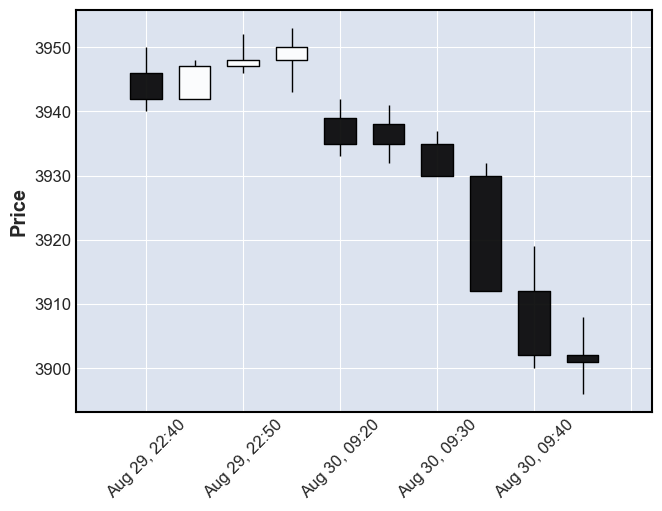

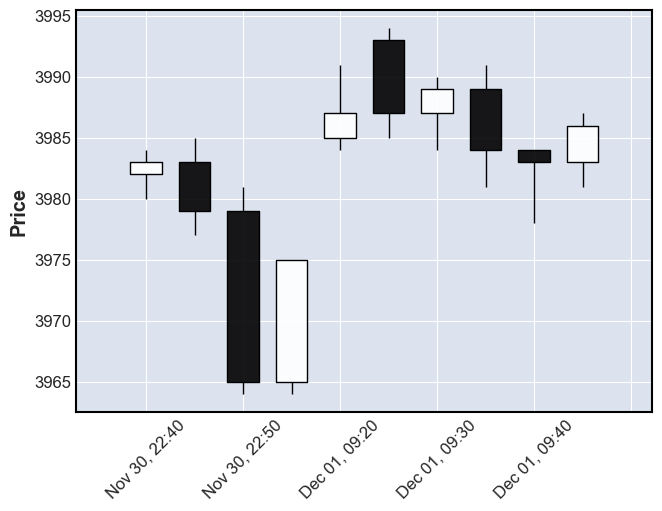

In [6]:
for i in range(1, len(contracts)):
    last_index_end = indexes[i-1][0][-5]
    this_index_start = indexes[i][0][5]
    tmp_df = train_df.iloc[last_index_end:this_index_start].set_index('date')
    tmp_df.index = pd.to_datetime(tmp_df.index)
    mpf.plot(tmp_df, type='candle')

# Get All Features

In [7]:
window_size = 125
individual_length = train_df[train_df.tic==tickers[0]].shape[0]
columns = GET_alpha(train_df[:window_size+5]).columns.to_list()
res_list = []
def data_processing(i, tmp_df):
    tmp_df_1 = tmp_df.iloc[i:i+window_size].copy()
    res = GET_alpha(tmp_df_1)
    clear_output()
    return res.iloc[-1].to_numpy()
for a in range(len(tickers)):
    tmp_df = train_df[train_df.tic==tickers[a]]
    res = Parallel(n_jobs=40)(delayed(data_processing)(i, tmp_df) for i in tqdm(range(individual_length-window_size)))
    res_list.append(res)
res_array = np.asarray(res_list)
res_array = res_array.reshape(res_array.shape[0]*res_array.shape[1], res_array.shape[-1])
res_df = pd.DataFrame(res_array)
res_df.columns = columns
for i in range(2, len(res_df.columns)):
    try:
        res_df[columns[i]] = res_df[columns[i]].values.astype('float64')
    except:
        print("Error: ", columns[i])
        res_df = res_df.drop(columns=columns[i])

res_df.shape, res_df.dtypes, res_df.head(5)

100%|██████████████████████████████████████████████████████████████████████████████| 6433/6433 [06:27<00:00, 16.60it/s]


Error:  underlaying_symbols


((6433, 144),
 date              object
 tic               object
 open             float64
 high             float64
 low              float64
 close            float64
 volume           float64
 open_oi          float64
 close_oi         float64
 alpha_191_1      float64
 alpha_191_2      float64
 alpha_191_5      float64
 alpha_191_6      float64
 alpha_191_7      float64
 alpha_191_8      float64
 alpha_191_9      float64
 alpha_191_11     float64
 alpha_191_12     float64
 alpha_191_13     float64
 alpha_191_14     float64
 alpha_191_15     float64
 alpha_191_16     float64
 alpha_191_17     float64
 alpha_191_18     float64
 alpha_191_20     float64
 alpha_191_22     float64
 alpha_191_24     float64
 alpha_191_25     float64
 alpha_191_26     float64
 alpha_191_28     float64
 alpha_191_29     float64
 alpha_191_31     float64
 alpha_191_32     float64
 alpha_191_33     float64
 alpha_191_34     float64
 alpha_191_35     float64
 alpha_191_36     float64
 alpha_191_37     float6

# Drop Features with Too Many Zeros
## If data set contains too many zeros, the agent will be very reluctant to trade.

In [8]:
columns_1 = res_df.columns
zeros_1 = ((res_df==0).sum()>res_df.shape[0]*0.05)
columns_to_drop_1 = np.where(zeros_1==True)[0]

columns_to_drop_1.shape

(6,)

In [9]:
for i in range(columns_to_drop_1.shape[0]):
    tmp_index = columns_to_drop_1[i]
    tmp_column = columns_1[tmp_index]
    res_df = res_df.drop(columns=tmp_column)

res_df.isna().sum(), res_df.shape, res_df.columns, res_df.head(5), res_df.tail(5)

(date                0
 tic                 0
 open                0
 high                0
 low                 0
 close               0
 volume              0
 open_oi             0
 close_oi            0
 alpha_191_1         0
 alpha_191_2         0
 alpha_191_5       211
 alpha_191_6         0
 alpha_191_7         0
 alpha_191_8         0
 alpha_191_9         0
 alpha_191_11        0
 alpha_191_12        0
 alpha_191_13        0
 alpha_191_14        0
 alpha_191_16        0
 alpha_191_17        0
 alpha_191_18        0
 alpha_191_20        0
 alpha_191_22        0
 alpha_191_24        0
 alpha_191_25     6433
 alpha_191_26     6433
 alpha_191_28        0
 alpha_191_29        0
 alpha_191_31        0
 alpha_191_32      144
 alpha_191_33     6433
 alpha_191_34        0
 alpha_191_35        0
 alpha_191_36        0
 alpha_191_37        0
 alpha_191_39        0
 alpha_191_41        0
 alpha_191_42        0
 alpha_191_44        0
 alpha_191_45     6433
 alpha_191_46        0
 alpha_191_

# Only Keep Valid Features

In [10]:
def IC_test(price, factor_values, shift=-1):
    next_term_return = pd.Series(price).pct_change().shift(shift).fillna(0).values
    factor_values = np.asarray(factor_values)
    factor_values = np.nan_to_num(factor_values)
    IC = np.corrcoef(factor_values, next_term_return)[0][-1]
    return IC

In [11]:
factors = res_df.columns[9:]
tickers = res_df.tic.unique()
corr_list = []
corr_df = pd.DataFrame()
for i in tqdm(range(len(factors))):
    tmp_corr_2 = []
    for a in tickers:
        tmp_df = res_df[res_df.tic==a]
        tmp_corr = IC_test(price=tmp_df.close.values, factor_values=tmp_df[factors[i]].values, shift=-1)
        tmp_corr_2.append(tmp_corr)
    corr_list.append(np.mean(tmp_corr))
        
corr_df['correlation'] = corr_list
corr_df['factors'] = factors
corr_df = corr_df.dropna()
corr_df = corr_df.drop(corr_df[corr_df.correlation==1].index)
corr_df = corr_df.sort_values(by="correlation",ascending=False)
valid_factors = []
valid_factors.append(corr_df.factors.values)
valid_factors = np.asarray(valid_factors)

corr_df.shape, corr_df.head(50), valid_factors

100%|████████████████████████████████████████████████████████████████████████████████| 129/129 [00:02<00:00, 44.06it/s]


((123, 2),
      correlation        factors
 44       0.02678   alpha_191_65
 77       0.02622  alpha_191_107
 33       0.02371   alpha_191_46
 24       0.02346   alpha_191_34
 86       0.02052  alpha_191_120
 72       0.02009   alpha_191_70
 89       0.01999  alpha_191_125
 108      0.01983  alpha_191_155
 9        0.01944   alpha_191_13
 29       0.01832   alpha_191_41
 128      0.01753  alpha_191_191
 87       0.01708  alpha_191_121
 118      0.01698  alpha_191_170
 115      0.01619  alpha_191_163
 79       0.01519  alpha_191_109
 65       0.01515   alpha_191_91
 81       0.01487  alpha_191_111
 37       0.01360   alpha_191_54
 30       0.01305   alpha_191_42
 78       0.01304  alpha_191_108
 101      0.01286  alpha_191_145
 121      0.01234  alpha_191_176
 125      0.01229  alpha_191_185
 56       0.01206   alpha_191_80
 12       0.01161   alpha_191_17
 100      0.01133  alpha_191_142
 95       0.01063  alpha_191_136
 61       0.01051   alpha_191_87
 34       0.01042   alpha_191_47

In [12]:
corr_df.to_csv(path+'新建文件夹\\corr_df_alpha_191.csv')
res_df.to_csv(path+'新建文件夹\\pre_processed_train_df_2_alpha_191.csv')